In [1]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

In [6]:
# Libraries
# ==============================================================================
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


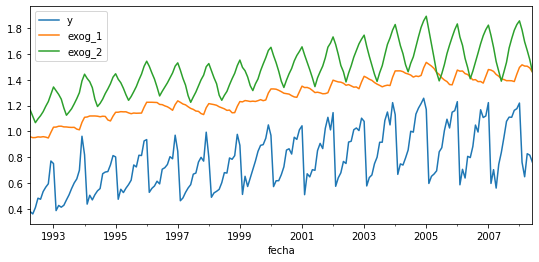

In [7]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

## ForecasterAutoreg

In [3]:
# Backtest forecaster with initial train
# ==============================================================================
n_backtest = 36*3 + 1 # Last 3 months are used for backtest
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 5 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data_train),
                                    steps      = 36,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest

Number of observations used for training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
Error de backtest: [0.09599272]


array([0.63315801, 0.65865648, 0.66087234, 0.66549297, 0.66174883,
       0.65936912, 0.65583442, 0.65385948, 0.65279822, 0.65282024,
       0.65324006, 0.65385758, 0.65436361, 0.65467689, 0.65478618,
       0.65476055, 0.6546645 , 0.65455928, 0.65447923, 0.6544362 ,
       0.65442538, 0.65443541, 0.65445384, 0.65447151, 0.65448366,
       0.65448932, 0.65448981, 0.65448734, 0.65448398, 0.65448111,
       0.65447933, 0.65447865, 0.65447877, 0.6544793 , 0.65447988,
       0.65448034, 0.65406535, 0.66559727, 0.66056579, 0.64688044,
       0.6407876 , 0.6486175 , 0.65036848, 0.65245733, 0.65519077,
       0.65637031, 0.65601601, 0.65564747, 0.65513761, 0.65458347,
       0.65426564, 0.65418531, 0.65420852, 0.65429668, 0.65440453,
       0.65448389, 0.65452385, 0.65453433, 0.6545247 , 0.65450613,
       0.65448869, 0.65447695, 0.65447146, 0.65447101, 0.65447351,
       0.65447683, 0.65447964, 0.65448138, 0.65448203, 0.6544819 ,
       0.65448138, 0.6544808 , 0.62288722, 0.64941878, 0.65194

In [63]:
import typing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf

def plot_residuals(residuals: np.array=None, y_true: np.array=None,
                   y_pred: np.array=None, ax: matplotlib.axes.Axes=None,
                   **kwargs):
    '''
    
    Parameters
    ----------
    residuals: np.array, default `None`.
        
    y_true: np.array, default `None`.
                   
    y_pred: np.array, default `None`. 
    
    fig: matplotlib.figure.Figure, default `None`. 
        Pre-existing fig for the plot. Otherwise, call matplotlib.pyplot.gca() internally.
        
    kwargs
        Other keyword arguments are passed to matplotlib.pyplot.figure()
    '''
    
    if residuals is None and (y_true is None or y_pred is None):
        raise Exception(
            "If `residuals` aregument is None then, y_true and y_pred must be provided."
        )
        
    if residuals is None:
        residuals = y_pred - y_true
        
    

    #TODO: icnluir índice temporal
    
    fig = plt.figure(constrained_layout=True, **kwargs)
    gs  = matplotlib.gridspec.GridSpec(2, 2, figure=fig)
    ax1 = plt.subplot(gs[0, :])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    
    ax1.plot(residuals)
    sns.histplot(residuals, kde=True, bins=30, ax=ax2)
    plot_acf(residuals, ax=ax3, lags=60)
    
    ax1.set_title("Residuals")
    ax2.set_title("Distribution")
    ax3.set_title("Autocorrelation")

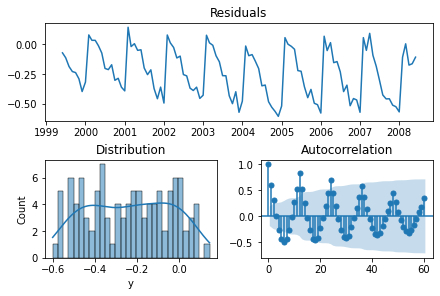

In [4]:
residuals = predictions_backtest - data_test.y
plot_residuals(residuals=residuals)

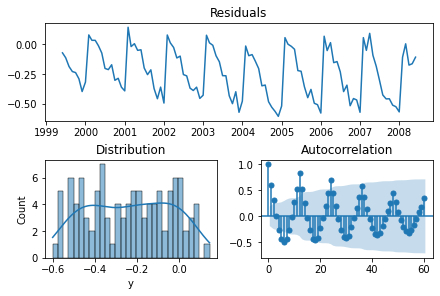

In [5]:
plot_residuals(y_true=data_test.y, y_pred=predictions_backtest)